In [ ]:
# potrebno za učitavanje mp3 datoteka
!apt install --assume-yes ffmpeg

In [2]:
import os
import pandas as pd
import numpy as np
import ast
import librosa
import librosa.display
import matplotlib.pyplot as plt
import warnings
from IPython.display import Audio

warnings.simplefilter('ignore', UserWarning)

In [3]:
# ID-ovi pjesama iz dataseta
track_ids = np.array([int(filename[:-4]) for dirname, _, filenames in os.walk('/kaggle/input/fma-small/fma_small/fma_small') for filename in filenames if filename.endswith('.mp3')])
track_ids

array([144809, 144941, 144943, ..., 145551, 145002, 145747])

In [4]:
# Pomoćna funkcija za traženje datoteka
def get_song_file(song_id):
    song_id_str = f'{song_id:06}'
    return f'/kaggle/input/fma-small/fma_small/fma_small/{song_id_str[:3]}/{song_id_str}.mp3'

In [5]:
# Učitajmo podatke o žanrovima
tracks = pd.read_csv('/kaggle/input/fma-small/fma_metadata/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
tracks = tracks.loc[track_ids, [('track', 'genres'), ('track', 'genres_all'), ('track', 'genre_top')]]
tracks.columns = tracks.columns.map(lambda pair: pair[1])
tracks[['genres', 'genres_all']] = tracks[['genres', 'genres_all']].applymap(ast.literal_eval)

tracks

,genres,genres_all,genre_top
track_id,,,
144809,[514],"[514, 38]",Experimental
144941,[10],[10],Pop
144943,[10],[10],Pop
144477,[103],"[17, 103]",Folk
144487,[1],"[1, 38]",Experimental
...,...,...,...
145257,"[64, 66, 88]","[64, 66, 12, 88, 25]",Rock
145653,[76],"[10, 76]",Pop
145551,"[17, 103]","[17, 103]",Folk


U DataFrame-u tracks imamo pjesme iz dataset indeksirane po id-u, stupaci genres i genres_all predstavljaju id žanrova kojima pripada. Ako ih je više, to znači da je možda i podžanr nekog žanra. U stupcu genre_top dan je jedan od 8 glavnih žanrova kojem pjesma pripada.

In [6]:
# Učitajmo podatke o imenima i povezanosti podžanrova
genres = pd.read_csv('/kaggle/input/fma-small/fma_metadata/fma_metadata/genres.csv', index_col=0)
genres

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
...,...,...,...,...
1032,60,102,Turkish,2
1060,30,46,Tango,2
1156,26,130,Fado,2


In [7]:
# Provjerimo je li za svaku pjesmu dan žanr:
tracks.isnull().sum()

genres        0
genres_all    0
genre_top     0
dtype: int64

In [8]:
# Provjerimo balansiranost skupa podataka:
tracks.groupby('genre_top').size()

genre_top
Electronic       1000
Experimental     1000
Folk             1000
Hip-Hop          1000
Instrumental     1000
International    1000
Pop              1000
Rock             1000
dtype: int64

In [9]:
# Pusti random pjesmu
random_track = tracks.sample(1).iloc[0]
print(random_track['genre_top'])
Audio(get_song_file(random_track.name))

Folk


In [10]:
# Učitajmo po jednu pjesmu iz svakog žanra:
n_genres = tracks['genre_top'].nunique()
tracks2 = tracks.reset_index().groupby('genre_top').first().reset_index().to_dict('list')
tracks2['ts'] = [librosa.load(get_song_file(track_id)) for track_id in tracks2['track_id']]

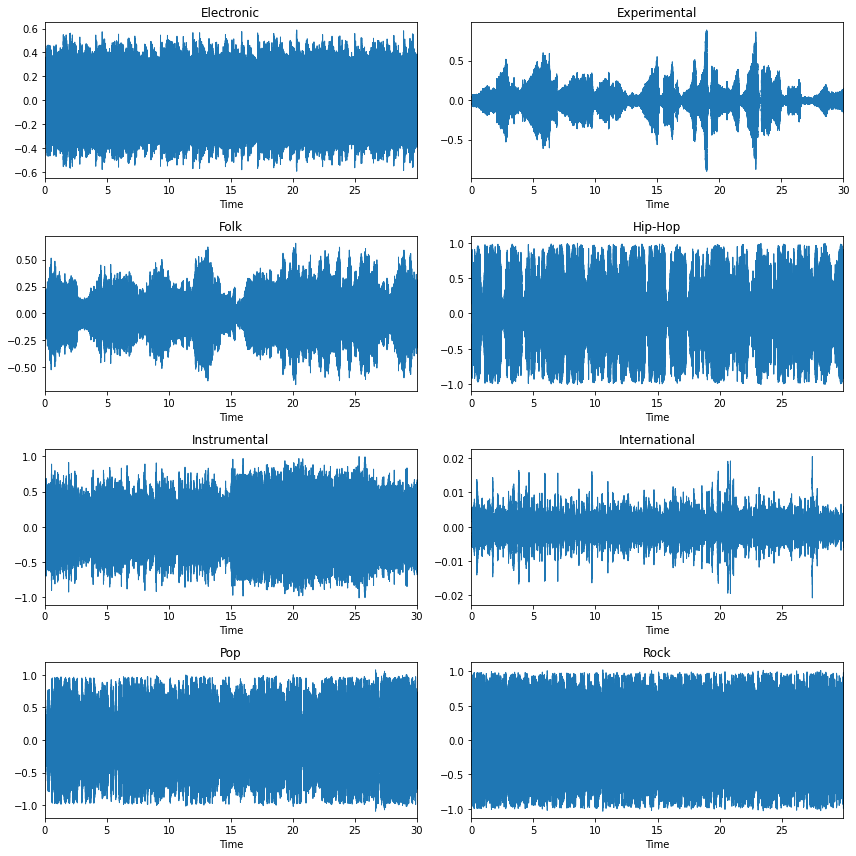

In [11]:
# Prikažimo waveplot-ove učitanih pjesama:
plt.figure(figsize=(12, 12))

for i in range(n_genres):
    plt.subplot(4, 2, i + 1)
    plt.title(tracks2['genre_top'][i])
    librosa.display.waveplot(tracks2['ts'][i][0], sr=tracks2['ts'][i][1])

plt.tight_layout()

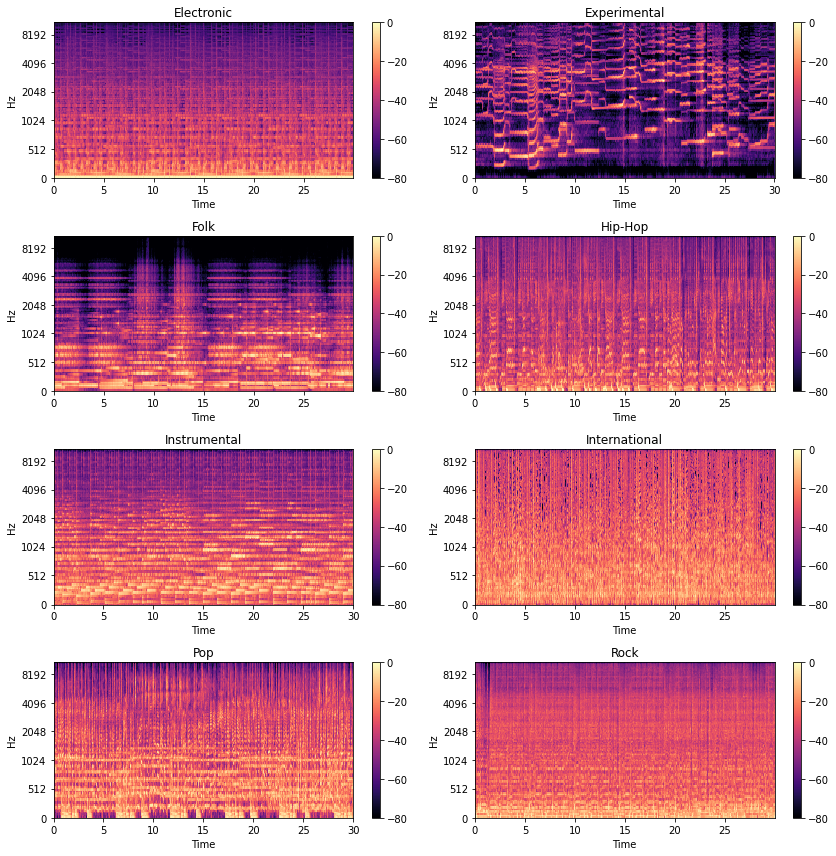

In [12]:
# Prikažimo Mel spektograme učitanih pjesama:
plt.figure(figsize=(12, 12))

for i in range(n_genres):
    plt.subplot(4, 2, i + 1)
    plt.title(tracks2['genre_top'][i])
    S = librosa.feature.melspectrogram(tracks2['ts'][i][0], sr=tracks2['ts'][i][1], n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    im = librosa.display.specshow(S_DB, sr=tracks2['ts'][i][1], hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar()

plt.tight_layout()

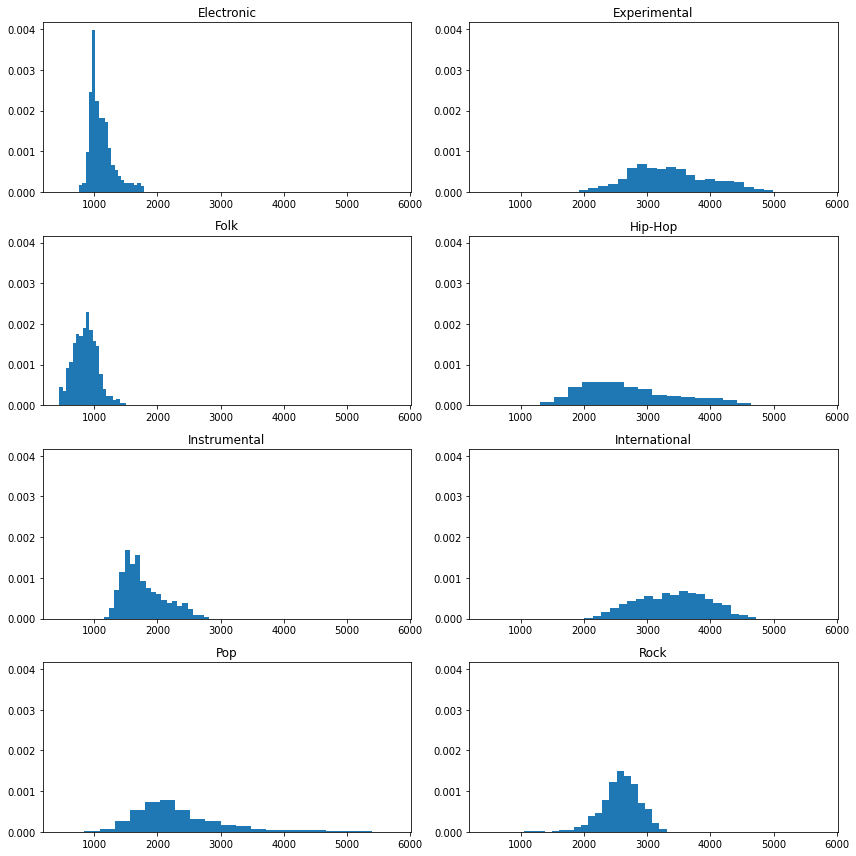

In [13]:
# Promotrimo histograme "prosječnih" frekvencija učitanih pjesma:
plt.figure(figsize=(12, 12))
ax1 = plt.subplot(4, 2, 1)

for i in range(n_genres):
    ax = plt.subplot(4, 2, i + 1, sharex=ax1, sharey=ax1)
    ax.set_title(tracks2['genre_top'][i])
    centroid = librosa.feature.spectral_centroid(tracks2['ts'][i][0], sr=tracks2['ts'][i][1])
    ax.hist(centroid.ravel(), bins=20, density=True)
    ax.tick_params(labelbottom=True,labelleft=True)

plt.tight_layout()

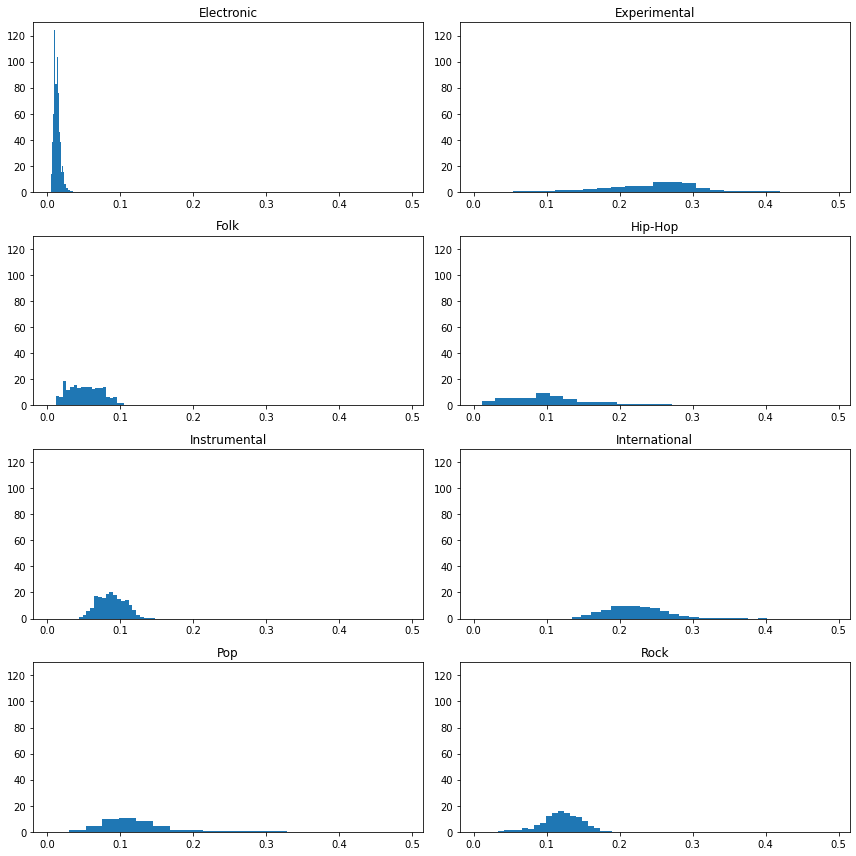

In [14]:
# Promotrimo histograme za "zero-crossing rate" učitanih pjesma:
plt.figure(figsize=(12, 12))
ax1 = plt.subplot(4, 2, 1)

for i in range(n_genres):
    ax = plt.subplot(4, 2, i + 1, sharex=ax1, sharey=ax1)
    ax.set_title(tracks2['genre_top'][i])
    centroid = librosa.feature.zero_crossing_rate(tracks2['ts'][i][0])
    ax.hist(centroid.ravel(), bins=20, density=True)
    ax.tick_params(labelbottom=True,labelleft=True)

plt.tight_layout()